<center><h1> Notebook for processing one file</h1>
*Scott Collis, Jonathan Helmus, Kirk North, Tim Lang, Kai Mühlbauer *
</center>


In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
#needs to be running under pyart35 environment
import pyart
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy import ndimage, signal, integrate
import time
import copy
import netCDF4
import skfuzzy as fuzz
import datetime
import platform
import fnmatch
import os
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


/Users/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the c

In [3]:
my_system = platform.system()
if my_system == 'Darwin':
    top = '/data/sample_sapr_data/sgpstage/sur/'
    soundings_dir = '/data/sample_sapr_data/sgpstage/interp_sonde/'
elif my_system == 'Linux':
    top = '/lcrc/group/earthscience/radar/sgpstage/sur/'
    soundings_dir = '/lcrc/group/earthscience/radar/interp_sonde/'

In [4]:
#python 2
import imp
radar_codes = imp.load_source('radar_codes', '/Users/scollis/projects/AGU_2016/scripts/processing_code.py')


In [5]:
radar_codes.hello_world()


('why hello ', 'First', ' wave')


In [6]:
radar = pyart.io.read('/data/sample_sapr_data/sgpstage/sur/20110520/110635.mdv')
print(radar.fields.keys())


['differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'specific_differential_phase', 'velocity']


In [7]:
i_end = 975
radar.range['data']=radar.range['data'][0:i_end]
for key in radar.fields.keys():
    radar.fields[key]['data']= radar.fields[key]['data'][:, 0:i_end]
radar.ngates = i_end

/Users/scollis/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/scollis/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


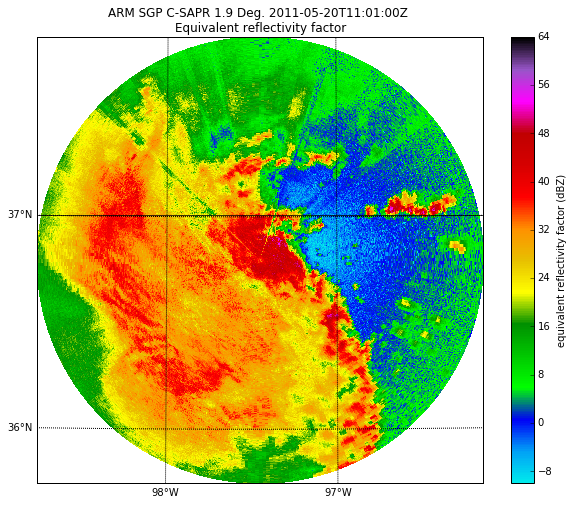

In [8]:

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'l',
                    vmin = -10, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef)



In [9]:
#guess a whole heap of data
radar_start_date = netCDF4.num2date(radar.time['data'][0], radar.time['units'])
print(radar_start_date)
ymd_string = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
hms_string = datetime.datetime.strftime(radar_start_date, '%H%M%S')
print(ymd_string, hms_string)

2011-05-20 11:01:00
('20110520', '110100')


In [10]:
z_dict, temp_dict, snr = radar_codes.snr_and_sounding(radar, soundings_dir)
texture =  radar_codes.get_texture(radar)

('sgpinterpolatedsondeC1.c1.20110520.*', 'sgpinterpolatedsondeC1.c1.20110520.000000.cdf')
159.477092028


In [11]:
radar.add_field('sounding_temperature', temp_dict, replace_existing = True)
radar.add_field('height', z_dict, replace_existing = True)
radar.add_field('SNR', snr, replace_existing = True)
radar.add_field('velocity_texture', texture, replace_existing = True)


In [12]:
my_fuzz, cats = radar_codes.do_my_fuzz(radar)

Doing no_scatter
Doing melting
Doing multi_trip
Doing rain
Doing snow
('Doing hard constraining ', 'melting')
(array([   0,    0,    0, ..., 6119, 6119, 6119]), array([ 0,  1,  2, ..., 26, 27, 28]))
('Doing hard constraining ', 'multi_trip')
(array([1800, 1800, 1800, ..., 6119, 6119, 6119]), array([966, 967, 968, ..., 972, 973, 974]))
('Doing hard constraining ', 'melting')
(array([ 720,  720,  720, ..., 6119, 6119, 6119]), array([893, 894, 895, ..., 972, 973, 974]))


In [13]:
radar.add_field('gate_id', my_fuzz, 
                      replace_existing = True)

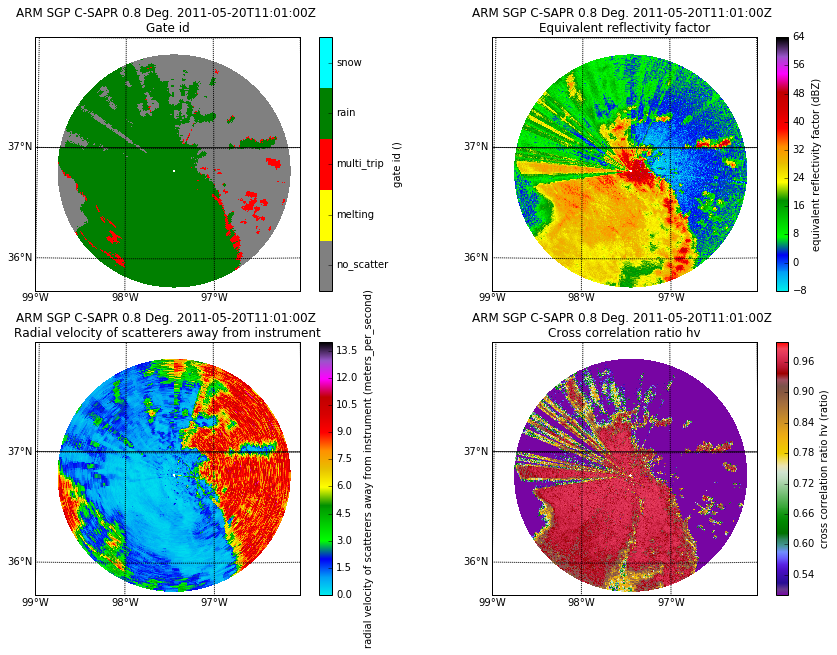

In [14]:
sw = 0
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

display = pyart.graph.RadarMapDisplay(radar)

f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = sw, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = cmap, vmin = 0, vmax = 5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep = sw, vmin = -8, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity_texture', sweep = sw, vmin =0, vmax = 14, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)
plt.subplot(2, 2, 4) 
display.plot_ppi_map('cross_correlation_ratio', sweep = sw, vmin = .5, vmax = 1,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.Carbone42)


In [15]:
print(radar.fields['gate_id']['notes'])

0: no_scatter 1: melting 2: multi_trip 3: rain 4: snow 


In [16]:
phidp, kdp = pyart.correct.phase_proc_lp(radar, 0.0, debug=True, fzl=3500.0)

Unfolding


/Users/scollis/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:188: RuntimeWarning: invalid value encountered in sqrt
  noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)


Exec time:  14.508300066
Doing  0


/Users/scollis/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:589: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  sct[np.where(sct < 0.0)] = 0.0
/Users/scollis/anaconda/lib/python2.7/site-packages/cylp-0.7.1-py2.7-macosx-10.6-x86_64.egg/cylp/py/modeling/CyLPModel.py:372: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if left == None:
/Users/scollis/anaconda/lib/python2.7/site-packages/cylp-0.7.1-py2.7-macosx-10.6-x86_64.egg/cylp/py/utils/sparseUtil.py:388: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if b == None:
/Users/scollis/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:925: FutureWarning: comparison to `None` will result in an elementwise object comparison in the fu

Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing  10
Doing  11
Doing  12
Doing  13
Doing  14
Doing  15
Doing  16


In [17]:
radar.add_field('corrected_differential_phase', phidp,replace_existing = True)
radar.add_field('corrected_specific_diff_phase', kdp,replace_existing = True)


In [18]:
height = radar.gate_altitude
lats = radar.gate_latitude
lons = radar.gate_longitude
lowest_lats = lats['data'][radar.sweep_start_ray_index['data'][0]:radar.sweep_end_ray_index['data'][0],:]
lowest_lons = lons['data'][radar.sweep_start_ray_index['data'][0]:radar.sweep_end_ray_index['data'][0],:]
c1_dis_lat = 36.605
c1_dis_lon = -97.485
cost = np.sqrt((lowest_lons - c1_dis_lon)**2 + (lowest_lats - c1_dis_lat)**2)
index = np.where(cost == cost.min())
lon_locn = lowest_lons[index]
lat_locn = lowest_lats[index]
print(lat_locn, lon_locn)


(array([ 36.60503233]), array([-97.4840059]))


In [19]:
my_system = platform.system()

if my_system == 'Darwin':
    top = '/data/sample_sapr_data/sgpstage/sur/'
    s_dir = '/data/sample_sapr_data/sgpstage/interp_sonde/'
    odir_r = '/data/sample_sapr_data/agu2016/radars/'
    odir_s = '/data/sample_sapr_data/agu2016/stats/'
    odir_i = '/data/sample_sapr_data/agu2016/images/'
elif my_system == 'Linux':
    top = '/lcrc/group/earthscience/radar/sgpstage/sur/'
    s_dir = '/lcrc/group/earthscience/radar/sgpstage/interp_sonde/'
    odir_r = '/lcrc/group/earthscience/radar/agu2016/radars/'
    odir_s = '/lcrc/group/earthscience/radar/agu2016/stats/'
    odir_i = '/lcrc/group/earthscience/radar/agu2016/images/'



In [20]:
dis_output_location = os.path.join(odir_s,ymd_string)
if not os.path.exists(dis_output_location):
    os.makedirs(dis_output_location)

In [21]:
dis_string = ''
time_of_dis = netCDF4.num2date(radar.time['data'], radar.time['units'])[index[0]][0]
tstring = datetime.datetime.strftime(time_of_dis, '%Y%m%d%H%H%S')
dis_string = dis_string + tstring + ' '
for key in radar.fields.keys():
    dis_string = dis_string + key + ' '
    dis_string = dis_string + str(radar.fields[key]['data'][index][0]) + ' '

In [22]:
write_dis_filename = os.path.join(dis_output_location,
                                 'csapr_distro_'+ymd_string+hms_string+'.txt')


In [23]:
dis_fh = open(write_dis_filename, 'w')
dis_fh.write(dis_string)
dis_fh.close()